# Process 24h mean, max and daytim/nightime max for downloaded PurpleAir files

Load all the PurpleAir QA/QC and smoke corrected data, write out a combined file. Process daily statistics.

### Load python packages

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import datetime
from pathlib import Path                   # System agnostic paths

import requests # for url requests
from statistics import median # for median of array
import json # for json reading/writing
import time # for epoch timestamp
import csv # for writing csv files
import glob # for listing files

### Create reusable functions

In [2]:
def fill_missing_dates(datafile, datetemplate):
    
    '''
    Function that collects corrected PurpleAir PM2.5 data from a processed file
    Requires a column: 'PM2.5_corrected'
    
    datafile (str): string path to file containing data
    datetemplate (datetime64): dates to fill with data or NAN, so can have consistent data array record
    
    returns: aq_array (float) is a data array of combined PM2.5 values with a datetemplate index
    
    '''
    
    station_meta = datafile.split('_')
    ID = station_meta[-4]
    name = station_meta[-3]
    lat = station_meta[-2]
    lon = station_meta[-1].split('.csv')[0]
    
    load_data = pd.read_csv(datafile, na_values='NaN', keep_default_na=False)
    PM25_loaded = pd.DataFrame(load_data['PM2.5_corrected'])
    PM25_loaded.index = pd.to_datetime(load_data['date (UTC)'])
    
    # Make sure data all has the same dimensions
    # Initialize the combined array
    aq_array = pd.DataFrame(columns = [ID], index = datetemplate)

    for d in datetemplate:
        #print(d)
        #if (PM25_loaded.loc[str(d)].values.size > 0):
        try:
            (PM25_loaded.loc[str(d)].values)
            #print('It exists')
            aq_array.loc[d] = PM25_loaded.loc[str(d)].values
        except:
            #print('No PA data for ', ID, ' at ' , d)
            continue

    return aq_array


In [3]:
def convert_AQI(PM_data):   
    
    '''
    Converts PM2.5 values to a PM2.5 AQI thresholds between 1 and 6 according to the EPA thresholds:
    1 Good
    2 Moderate
    3 Unhealthy for Sensitive Groups
    4 Unhealthy
    5 Very Unhealthy
    6 Hazardous
    
    requires: PM_data -- a pandas data array read in from a csv file with the fill_missing_dates function
    
    returns: final_aqi data array with values between 1 and 6
    '''
    
    final_aqi = PM_data.copy()
    # mask changes everything that does not satisfy the condition
    # for example the first line below leaves everything where 
    # final data is greater than 12, but replaces 12 or less with 1.
    final_aqi = final_aqi.where(final_aqi>12.1 ,1)
    final_aqi = final_aqi.where((final_aqi<12.1) | (final_aqi> 35.5),2)
    final_aqi = final_aqi.where((final_aqi<35.5) | (final_aqi> 55.5),3)
    final_aqi = final_aqi.where((final_aqi<55.5) | (final_aqi> 150.5),4)
    final_aqi = final_aqi.where((final_aqi<150.5) | (final_aqi> 250),5)
    final_aqi = final_aqi.where(final_aqi<250.0,6)
    # fill in all the NaN values again
    final_aqi = final_aqi.where(PM_data.notna() , np.nan)


    return final_aqi

### Write 24 hourly and 12-hourly values - AQI are for GIS Story Map

Local time in Sonoma County:
(PST is 8 hours behind UTC)

* 24-hour avg: 0:00 - 23:00 PST = 08:00 UTC – 07:00 (+1day) UTC (mean midnight – 11pm PST)
* 24-hour max: 0:00 - 23:00 PST = 08:00 UTC – 07:00 (+1day) UTC (max midnight – 11pm PST)
* Nighttime max: 20:00 (-1day) - 08:00 PST = 04:00 UTC – 16:00 UTC (max 8pm – 8am PST)
* Daytime max: 8:00 - 20:00 PST = 16:00 UTC – 04:00 (+1day) UTC (max 8am – 8pm PST)

In [4]:
files = glob.glob("example_data/processed_hourly_sensor_data_2020/*.csv")

In [5]:
base_date = pd.date_range(start='2020-08-01 00:00:00+00:00', end='2020-11-06 23:00:00+00:00', freq='H')

In [6]:
count = 0

#for file in files[0:5]:
for file in files:
    print(file)
    array = fill_missing_dates(file, base_date)
    
    if count == 0:
    #   print('collecting first record)
        PM25_data = array
        count += 1
    else:
        temp = PM25_data
        newdata = array

        PM25_data = pd.concat([temp, newdata], axis=1)


PM25_data

example_data/processed_hourly_sensor_data_2020/PurpleAir_processed_3318_VillageEastDrive_38.247944_-122.60063.csv
example_data/processed_hourly_sensor_data_2020/PurpleAir_processed_3184_Imola6_38.3051_-122.288994.csv
example_data/processed_hourly_sensor_data_2020/PurpleAir_processed_3247_Imola-2_38.28229_-122.25759.csv
example_data/processed_hourly_sensor_data_2020/PurpleAir_processed_3631_MeadowCt_38.407654_-122.83102.csv
example_data/processed_hourly_sensor_data_2020/PurpleAir_processed_3848_MARINCC_38.259796_-122.63819.csv


,3318,3184,3247,3631,3848
2020-08-01 00:00:00+00:00,4.3786,NaN,4.8262,NaN,3.9996
2020-08-01 01:00:00+00:00,NaN,NaN,4.9098,NaN,4.1939
2020-08-01 02:00:00+00:00,4.09,NaN,5.0219,NaN,3.9026
2020-08-01 03:00:00+00:00,3.5225,NaN,4.0251,NaN,3.413
2020-08-01 04:00:00+00:00,3.4107,NaN,3.6772,NaN,3.0921
...,...,...,...,...,...
2020-11-06 19:00:00+00:00,2.8495,NaN,2.9378,-0.4888,3.7065
2020-11-06 20:00:00+00:00,2.8665,NaN,3.2295,-0.7725,3.4572
2020-11-06 21:00:00+00:00,2.5867,NaN,3.1729,2.1132,2.7952
2020-11-06 22:00:00+00:00,2.0682,NaN,2.8632,0.4907,2.2419


In [7]:
# convert to local time
PM25_data.index = PM25_data.index.tz_convert('Etc/GMT+8')
PM25_data.index.name = 'Date (US/Pacific Standard Time)'
PM25_data = PM25_data.astype(float, errors = 'raise')


In [8]:
#Filter 24 hour period for 25% of data or more
# Count number of values in a local time day
daily_count = PM25_data.resample('D').count()
# Create array same shape as PM2.5 with the daily counts
expanded_dcount = pd.DataFrame(np.zeros_like(PM25_data), dtype='int64', 
                               columns=PM25_data.columns, index=PM25_data.index)

for row in PM25_data.index:
    # replace row with counts
    expanded_dcount.loc[str(row)]=daily_count.loc[str(row.date())].values

#expanded_dcount

In [9]:
# mask where less than 90% of hourly data exists
# i.e. need 22 out of 24 hours or more
filtered_PM25_data = PM25_data.where(expanded_dcount >= 22)

In [10]:
filtered_datacount = np.count_nonzero(~np.isnan(filtered_PM25_data))
orig_datacount = np.count_nonzero(~np.isnan(PM25_data))
countdiff = orig_datacount-filtered_datacount
print('Data loss = '+ str(orig_datacount) +'-'+ str(filtered_datacount) +'=' +str(countdiff))
print(str((countdiff/filtered_datacount)*100) + '%')

Data loss = 8729-8299=430
5.181347150259067%


In [11]:
#PM25_data
filtered_PM25_data.to_csv('example_data/2020/concatenated_stations_2020_PurpleAir_hourly_filtered90perc.csv',na_rep='NAN', date_format='%Y%m%d %H:%M')

### Daily processing

In [12]:
# 24 h average
day_avg = PM25_data.resample('D').mean()
# 24 h max
day_max = PM25_data.resample('D').apply(lambda x : max(x, key = abs))

# Need 22 hours (>90%) to get a daily average or max
daily_count = PM25_data.resample('D').count()
subset_day_avg = day_avg.where(daily_count >= 22)
subset_day_max = day_max.where(daily_count >= 22)

subset_day_avg_round = subset_day_avg.round(decimals=4)
subset_day_max_round = subset_day_max.round(decimals=4)

#print(subset_day_avg_round, subset_day_max_round)

### Day/Night Processing

In [13]:
# 12 hr max, 8 to 8
diurnal_max = PM25_data.resample('12H', loffset='8H').apply(lambda x : max(x, key = abs))

# Need 11 hours (>90%) to get a daily average or max
diurnal_count = PM25_data.resample('12H', loffset='8H').count()
subset_diurnal_max = diurnal_max.where(diurnal_count >= 11)
subset_diurnal_max_round = subset_diurnal_max.round(decimals=4)

daytime_max = subset_diurnal_max_round[1::2]
nighttime_max = subset_diurnal_max_round[::2]

#subset_diurnal_max_round

<ipython-input-13-8cdb18582af0>:2: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  diurnal_max = PM25_data.resample('12H', loffset='8H').apply(lambda x : max(x, key = abs))
<ipython-input-13-8cdb18582af0>:5: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  diurnal_count = PM25_data.resample('12H', loffset='8H').count()


### Write to csv files

In [14]:
subset_day_avg_round.to_csv('example_data/2020/concatenated_stations_2020_PurpleAir_dayavg.csv',na_rep='NAN', date_format='%Y%m%d %H:%M')
subset_day_max_round.to_csv('example_data/2020/concatenated_stations_2020_PurpleAir_daymax.csv',na_rep='NAN', date_format='%Y%m%d %H:%M')
daytime_max.to_csv('example_data/2020/concatenated_stations_2020_PurpleAir_daytimemax.csv',na_rep='NAN', date_format='%Y%m%d %H:%M')
nighttime_max.to_csv('example_data/2020/concatenated_stations_2020_PurpleAir_nighttimemax.csv',na_rep='NAN', date_format='%Y%m%d %H:%M')

## Convert to AQI

In [15]:
daytime_max_AQI = convert_AQI(daytime_max)
nighttime_max_AQI = convert_AQI(nighttime_max)
day_avg_AQI = convert_AQI(subset_day_avg_round)
day_max_AQI = convert_AQI(subset_day_max_round)


## Convert to GSI-specific format

In [16]:
daytime_max_AQI = daytime_max_AQI.astype(float, errors = 'raise')
nighttime_max_AQI = nighttime_max_AQI.astype(float, errors = 'raise')
day_avg_AQI = day_avg_AQI.astype(float, errors = 'raise')
day_max_AQI = day_max_AQI.astype(float, errors = 'raise')

In [17]:
def format_gsi(dataframe):
    count = 0
    
    for title in dataframe.columns:
        #print(title)
        extract_station = pd.DataFrame(dataframe[title])
        extract_station.columns = ['AQI_cat']
        extract_station['Station_ID'] = title
        #print(extract_station)
        if count == 0:
            #   print('collecting first record)PM25_data = array
            gsi_PM25_data = extract_station
            count += 1
            #print(gsi_PM25_data)

        else:
            temp = gsi_PM25_data
            newdata = extract_station
            
            gsi_PM25_data = pd.concat([temp, newdata], axis=0)
            #gsi_PM25_data = gsi_PM25_data.append(extract_station)
            #print(gsi_PM25_data)

        del(extract_station)

    return gsi_PM25_data

In [18]:
#extract_station = pd.DataFrame(day_max_AQI['18911'])
#extract_station.columns = ['AQI_cat']
#extract_station

In [19]:
gsi_dayavg = format_gsi(day_avg_AQI)
gsi_daymax = format_gsi(day_max_AQI)
gsi_daytimemax = format_gsi(daytime_max_AQI)
gsi_nighttimemax = format_gsi(nighttime_max_AQI)

### Write to csv

In [20]:
gsi_dayavg.to_csv('example_data/2020/AQI_stations_2020_PurpleAir_dayavg.csv',na_rep='NAN', date_format='%Y%m%d %H:%M')
gsi_daymax.to_csv('example_data/2020/AQI_stations_2020_PurpleAir_daymax.csv',na_rep='NAN', date_format='%Y%m%d %H:%M')
gsi_daytimemax.to_csv('example_data/2020/AQI_stations_2020_PurpleAir_daytimemax.csv',na_rep='NAN', date_format='%Y%m%d %H:%M')
gsi_nighttimemax.to_csv('example_data/2020/AQI_stations_2020_PurpleAir_nighttimemax.csv',na_rep='NAN', date_format='%Y%m%d %H:%M')

### Plot the values

In [21]:
# Re-usable plotting call
def ts_plot(time_arr,val_arr,color_choice,label_string,dashpattern):
    plt.plot(time_arr, val_arr,dashpattern,label=label_string,
         color=color_choice, linewidth=2.5,
         markerfacecolor=color_choice,
         markeredgecolor='grey',
         markeredgewidth=1)


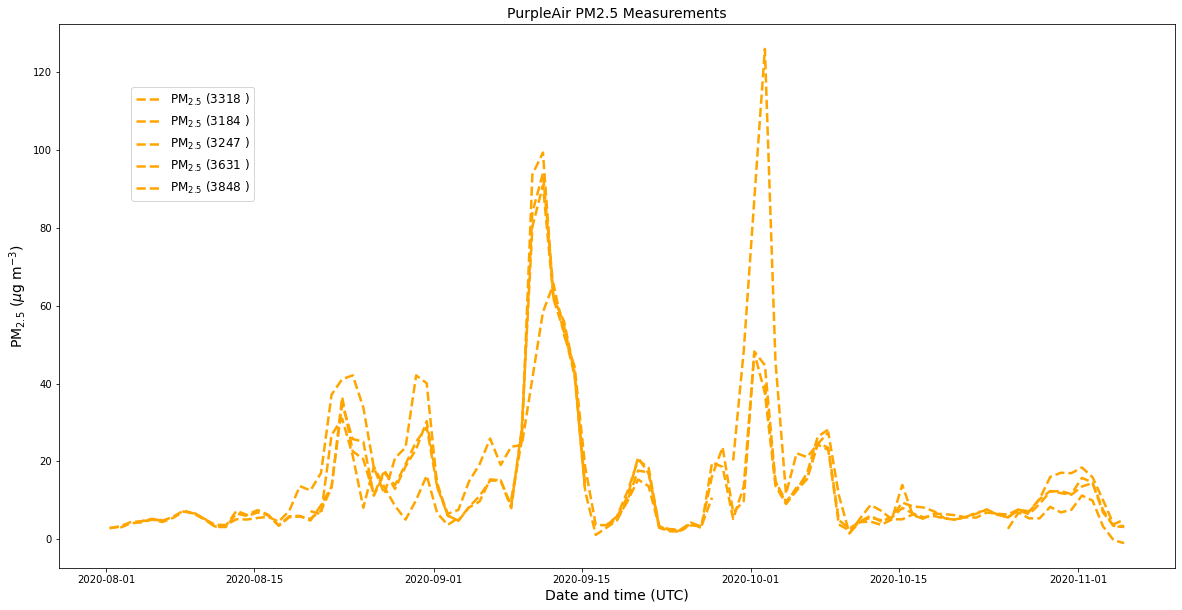

In [22]:
plt.figure(figsize=(20,10))
ax = plt.axes()

for sensor_id in subset_day_avg_round.columns:
    #print(sensor_id)
    ts_plot(subset_day_avg_round.index.values,subset_day_avg_round[sensor_id],'orange',r'PM$_{2.5}$ ('+str(sensor_id)+' )','--')
    

#titles
plt.title('PurpleAir PM2.5 Measurements',fontsize=14)
#plt.title('PurpleAir AQI Measurements',fontsize=14)
plt.xlabel('Date and time (UTC)',fontsize=14)
plt.ylabel(r'PM$_{2.5}$ ($\mu$g m$^{-3}$)',fontsize=14)

plt.legend(bbox_to_anchor=(0.12, 0.78),loc='center',fontsize=12)



plt.show() 